In [11]:
import sys
import pandas as pd
import os
from IPython.display import display
import graphviz

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

def visualize_request_flow(fn, counter=None, plot_first_hop_only=False, include_legend=True, routing_rule=None):
    df = pd.read_csv(fn)
    if counter is not None and counter > 0:
        df = df[df['counter'] == counter]
    
    grouped_df = df.groupby(['counter', 'src_svc', 'dst_svc', 'src_cid', 'dst_cid']).agg({'flow': 'sum', 'total': 'max'}).reset_index()
    grouped_df['weight'] = grouped_df['flow'] / grouped_df['total']

    node_color_dict = {
        "XXXX": "gray",
        "-1": "#FFBF00",
        "us-west-1": "#FFBF00",
        "us-east-1": "#ff6375",
        "us-south-1": "#bbfbfc",
        "us-central-1": "#c8ffbf"
    }

    g_ = graphviz.Digraph()
    node_pw = "1.2"
    node_fs = "12"
    node_width = "0.5"

    edge_pw = "1.0"
    edge_fs = "10"
    edge_arrowsize = "1.0"
    edge_minlen = "1.2"

    edge_color_dict = {
        "sslateingress@POST@/cart/checkout": "blue",
        "sslateingress@POST@/cart": "red",
        "sslateingress@POST@/cart/empty": "darkgreen",
        "sslateingress@POST@/setCurrency": "orange",
        "frontend@POST@/cart/checkout": "blue",
        "frontend@POST@/cart": "red",
        "frontend@POST@/cart/empty": "darkgreen",
        "frontend@POST@/setCurrency": "orange",
        "sslateingress@POST@/multicore": "blue",
        "sslateingress@POST@/singlecore": "red",
    }

    for index, row in df.iterrows():
        src_cid = row["src_cid"]
        dst_cid = row["dst_cid"]
        src_svc = row["src_svc"].split("-")[-1]
        dst_svc = row["dst_svc"].split("-")[-1]
        src_node_name = src_svc + str(src_cid)
        dst_node_name = dst_svc + str(dst_cid)

        src_node_label = src_svc
        dst_node_label = dst_svc

        if src_svc == "SOURCE":
            edge_style = 'filled'
        elif src_cid == dst_cid:
            edge_style = 'filled'
        else:
            edge_style = 'dashed'

        edge_color = edge_color_dict.get(row["src_endpoint"], "black")

        try:
            src_node_color = node_color_dict.get(src_cid, "white")
            dst_node_color = node_color_dict.get(dst_cid, "white")

            g_.node(name=src_node_name, label=src_node_label[:4], shape='circle', style='filled', fillcolor=src_node_color, penwidth=node_pw, fontsize=node_fs, fixedsize="True", width=node_width)
            g_.node(name=dst_node_name, label=dst_node_label[:4], shape='circle', style='filled', fillcolor=dst_node_color, penwidth=node_pw, fontsize=node_fs, fixedsize="True", width=node_width)

            edge_label = f'{round(row["flow"], 1)}({int(round(row["weight"], 2) * 100)}%)'
            g_.edge(src_node_name, dst_node_name, label=edge_label, penwidth=edge_pw, style=edge_style, fontsize=edge_fs, fontcolor=edge_color, color=edge_color, arrowsize=edge_arrowsize, minlen=edge_minlen)

        except Exception as e:
            print(f"Error: {e}")
            print(f"Error row: {row}")

    # Add compact legend if include_legend is True
    if include_legend:
        with g_.subgraph(name="cluster_legend") as legend:
            legend.attr(label="Legend", fontsize="12", style="dashed")
            legend.node("west", "us-west-1", shape="circle", style="filled", fillcolor="#FFBF00", width="0.4", fontsize="10")
            legend.node("east", "us-east-1", shape="circle", style="filled", fillcolor="#ff6375", width="0.4", fontsize="10")
            legend.node("south", "us-south-1", shape="circle", style="filled", fillcolor="#bbfbfc", width="0.4", fontsize="10")
            legend.node("central", "us-central-1", shape="circle", style="filled", fillcolor="#c8ffbf", width="0.4", fontsize="10")
            legend.node("unknown", "Unknown", shape="circle", style="filled", fillcolor="gray", width="0.4", fontsize="10")

            # Arrange legend nodes in a single row
            legend.attr(rankdir="LR")
            legend.edge("west", "east", style="invis")
            legend.edge("east", "south", style="invis")
            legend.edge("south", "central", style="invis")
            legend.edge("central", "unknown", style="invis")

    return g_


def run(input_file, include_legend=True):
    g_ = visualize_request_flow(input_file, counter=None, plot_first_hop_only=False, include_legend=include_legend)
    pwd = os.getcwd()
    output_file = f"{pwd}/{input_file.split('.')[0]}"
    print(f"** Saved routing visualization: {output_file}.pdf")
    g_.render(output_file)
    return g_

** Saved routing visualization: /users/gangmuk/projects/client/plot_script/request_flow.pdf


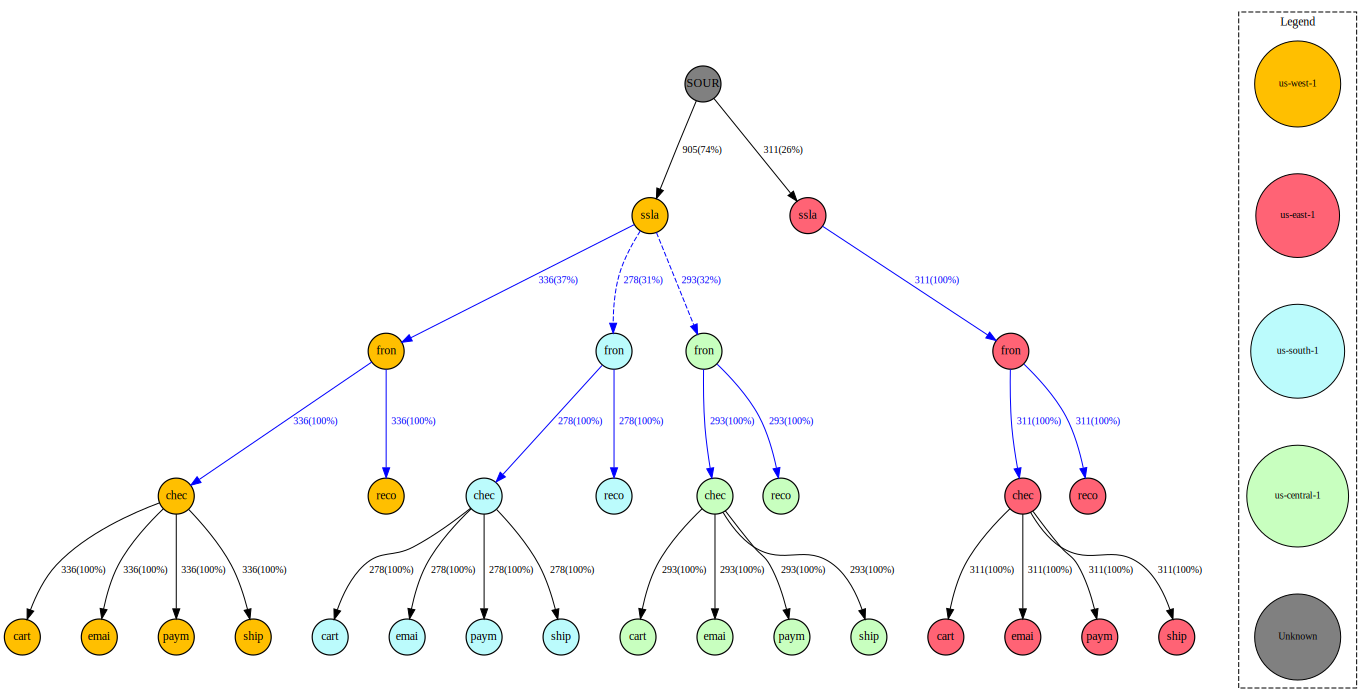

In [13]:
input_file = "request_flow.csv"
g_ = run(input_file, include_legend=True)
g_